In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D
from matplotlib import pyplot
from math import sqrt
from numpy import mean
from numpy import std
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

canada_sars = pd.read_csv('./data/sars_canada.csv', header = 0, index_col = 0, usecols=['date', 'cumulative_cases'])
canada_covid = pd.read_csv('./data/covid_canada.csv', header = 0, index_col = 0, usecols=['date', 'cumulative_cases'])

# Splits univariate dataset into training and testing data
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# Data as arrays
data_train = canada_sars.values
data_test = canada_covid.values



Using TensorFlow backend.


In [2]:
# Shift data for supervised learning, one-step forecast
def shift_data(data, n_in=1, n_out=1):
    df = pd.DataFrame(data)
    col = list()
    
    # Create two seperate columns, one original, one shifted forward
    
    # Input- nonchanged
    for i in range(n_in, 0, -1):
        col.append(df.shift(i))
        
    # Output- shifted forward 1 
    for i in range(0, n_out):
        col.append(df.shift(-i))
        
    result = pd.concat(col, axis=1)
    result.dropna(inplace=True)

    return result.values

def rmse_error(actual, predicted):
    # Print acutal and predicted of last data value
    print('Actual: ' + f'{actual[len(actual) - 1][0]}')
    print('Predicted: %.0f' % (predicted[len(predicted) - 1][0]))
    
    # Display plot of actual vs predicted values
    pyplot.plot(actual, label='Actual')
    pyplot.plot(predicted, label='Predicted')
    pyplot.legend()
    pyplot.show()
    
    # Return mean squared error
    return sqrt(mean_squared_error(actual, predicted))

def walk_forward_validation(train_data, test_data, cfg):
    prediction = list()
    
    # fit model
    model = fit_model(train_data, cfg)
    
    # seed history with training data
    history = [x for x in train_data]
    
    for i in range(len(test_data)):
        # fit model and make forecast for history
        yhat = predict_model(model, history,cfg)
        
        # store forecast
        prediction.append(yhat)
        # add observation to history for next loop
        history.append(test_data[i]);
    
    # estimate error
    error = rmse_error(test_data, prediction)
    print('Error: ' + '%.3f' % error)
    return error

def repeat_eval(train_data, test_data, cfg, repeats):
    scores = list()
    
    for i in range(repeats):
        print('\nIteration: %.0f' % (i + 1))
        scores.append(walk_forward_validation(train_data, test_data, cfg))
        
    return scores

def summarize(name, scores):
    score_mean, score_std = mean(scores), std(scores)
    print('\n%s: %.3f RMSE (+/- %.3f)' % (name, score_mean, score_std))
    
    pyplot.boxplot(score_list)
    pyplot.show()
        
    
def fit_model(train, config):
    n_input, n_nodes, n_epochs, n_batch = config
    data = shift_data(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

def predict_model(model, history, config):
    n_input, _, _, _ = config
    x_input = array(history[-n_input:]).reshape(1, n_input)
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

config = [12, 500, 100, 100]




Iteration: 1
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Actual: 68848
Predicted: 67581


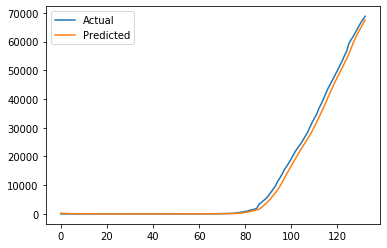

Error: 1486.351

Iteration: 2
Actual: 68848
Predicted: 66688


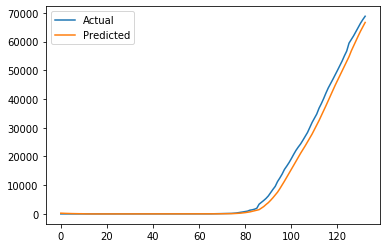

Error: 2094.792

Iteration: 3
Actual: 68848
Predicted: 67292


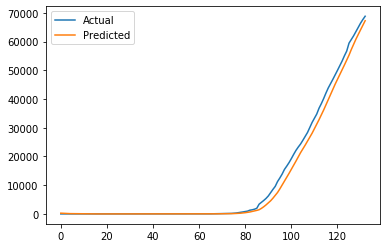

Error: 1965.856

Iteration: 4
Actual: 68848
Predicted: 68025


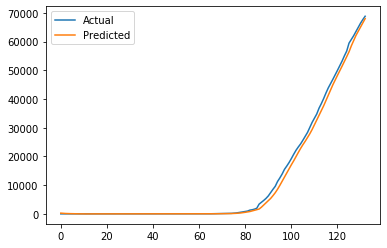

Error: 1234.860

Iteration: 5
Actual: 68848
Predicted: 66779


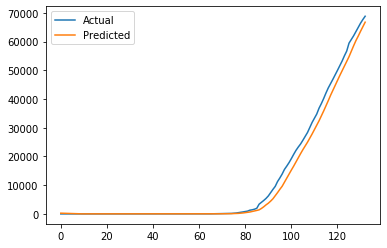

Error: 2154.865

Iteration: 6
Actual: 68848
Predicted: 67541


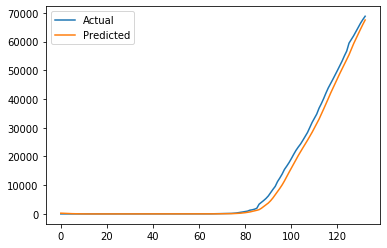

Error: 1818.549

Iteration: 7
Actual: 68848
Predicted: 68231


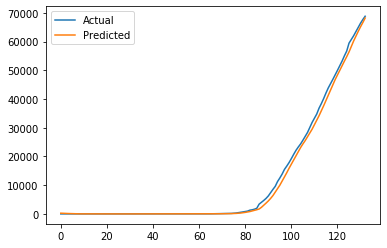

Error: 1187.760

Iteration: 8
Actual: 68848
Predicted: 67475


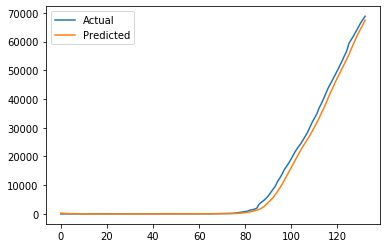

Error: 1698.592

Iteration: 9
Actual: 68848
Predicted: 67871


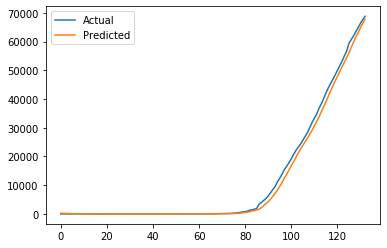

Error: 1398.849

Iteration: 10
Actual: 68848
Predicted: 67036


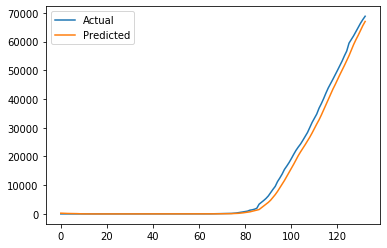

Error: 1912.415

CNN: 1695.289 RMSE (+/- 332.788)


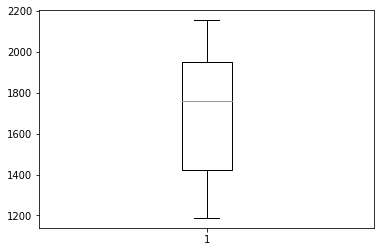

In [3]:
score_list = repeat_eval(data_train, data_test, config, 10)
summarize('CNN', score_list)